In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit, prange
import time
import random


#set the parameters
h=6.62607004e-34
hbar=h/2/np.pi
e=1.6021765e-19
epsilon0=8.8541878176e-12

f=5e9
R0=50.
#C0=3.9*epsilon0/(280e-9)*(100e-6)*(150e-6)
C0=2.5e-12
Rj=180.
Cj=C0/1e4
Ic=0.85e-6
sigma=3.645 #standard deviation of In
Rtime=1000

r0=R0/Rj
t0=hbar/2/e/Ic/Rj
rc0=R0*C0/t0
rcj=Rj*Cj/t0
eta=2*np.pi*f*t0
wp=np.sqrt(2*e*Ic/hbar/C0)

#r0=0.13
#eta=0.057
#rc0=200
#rcj=0.0612

n=1000
dt=2*np.pi/eta/n
dthalf=dt/2.0

@njit
def cpr(x):
    x0=x%(2*np.pi)
    if x0<np.pi:
        r=-x0/np.pi
    else:
        r=-x0/np.pi+2
    return r
    #return np.sin(x)
    #return np.cos(x/2)*np.arctanh(np.sin(x/2))
    #return (7./16*np.sin(x)+7./64*np.sin(2*x)+1./48*np.sin(3*x)+1./512*np.sin(4*x))*2

#################################################################################################################
#####2nd order when Cj=0
####################################################################################################################
@njit
def uj_0Cj(phi,u):
    return (u-r0*cpr(phi))/(1+r0)
    #return (u-r0*cpr(phi))/(1+r0*(1+np.cos(phi)))

@njit
def Dphi2(phi,u,tau,i0,i1):
    return uj_0Cj(phi,u)

@njit
def Du2(phi,u,tau,i0,i1):
    return (random.gauss(0,sigma)+i0+i1*np.sin(eta*tau)-cpr(phi)-Dphi2(phi,u,tau,i0,i1))*r0/rc0
    #return (i0+i1*np.sin(eta*tau)-cpr(phi)-Dphi2(phi,u,tau,i0,i1)*(1+np.cos(phi)))*r0/rc0

@njit
def runge_kutta_2(phi,u,t,alpha0,alpha1): #runge_kutta method for 2nd order ODE
	#calculate the slopes
	k1=Du2(phi,u,t,alpha0,alpha1)
	l1=Dphi2(phi,u,t,alpha0,alpha1)
	k2=Du2(phi+l1*dthalf,u+k1*dthalf,t+dthalf,alpha0,alpha1)
	l2=Dphi2(phi+l1*dthalf,u+k1*dthalf,t+dthalf,alpha0,alpha1)
	k3=Du2(phi+l2*dthalf,u+k2*dthalf,t+dthalf,alpha0,alpha1)
	l3=Dphi2(phi+l2*dthalf,u+k2*dthalf,t+dthalf,alpha0,alpha1)
	k4=Du2(phi+l3*dt,u+k3*dt,t+dt,alpha0,alpha1)
	l4=Dphi2(phi+l3*dt,u+k3*dt,t+dt,alpha0,alpha1)
	#calculate the new values
	un=u+(k1+2*k2+2*k3+k4)/6.0*dt
	phin=phi+(l1+2*l2+2*l3+l4)/6.0*dt
	tn=t+dt
	return phin,un,tn

@njit
def calculate_2(i0,i1,phi0,u0,nt):
	L=nt*n
	phi=np.zeros(L)
	u=np.zeros(L)
	tau=np.zeros(L)
    
	phi[0]=phi0 
	u[0]=u0 
    
	for i in range(L-1):
		phi[i+1],u[i+1],tau[i+1] = runge_kutta_2(phi[i],u[i],tau[i],i0,i1)
	return (phi[-1]-phi[0])/(tau[-1]-tau[0]),phi[-1],u[-1]

#add noise: phi + random.gauss(0,0.053); u + random.gauss(0,0.001)

@njit(parallel=True)
def loop_2(V0,I,P):
    for i in prange(len(P)):
        V0[0,i],phi0,u0 = calculate_2(I[0],P[i],0,0,100)
        for j in range(len(I)):
            V0[j,i],phi0,u0 = calculate_2(I[j],P[i],phi0,u0,Rtime)
    return V0


###############################################################################################################
#####3rd orde when Cj is not 0-------------------
################################################################################################################

@njit
def D_phi(phi,u,uj,tau,i0,i1): #derivative of phi
	return uj

@njit
def D_u(phi,u,uj,tau,i0,i1): #derivative of u
	return (r0*(i0+i1*np.sin(eta*tau))-u+uj)/rc0

@njit
def D_uj(phi,u,uj,tau,i0,i1): #derivative of uj
	return (u/r0-cpr(phi)-uj*(1+1/r0))/rcj


@njit
def runge_kutta_3(phi,u,uj,tau,i0,i1): #runge_kutta method for 2nd order ODE
	#calculate the slopes
	k1=D_phi(phi,u,uj,tau,i0,i1)
	l1=D_u(phi,u,uj,tau,i0,i1)
	m1=D_uj(phi,u,uj,tau,i0,i1)
    
	k2=D_phi(phi+k1*dthalf,u+l1*dthalf,uj+m1*dthalf,tau+dthalf,i0,i1)
	l2=D_u(phi+k1*dthalf,u+l1*dthalf,uj+m1*dthalf,tau+dthalf,i0,i1)
	m2=D_uj(phi+k1*dthalf,u+l1*dthalf,uj+m1*dthalf,tau+dthalf,i0,i1)
    
	k3=D_phi(phi+k2*dthalf,u+l2*dthalf,uj+m2*dthalf,tau+dthalf,i0,i1)
	l3=D_u(phi+k2*dthalf,u+l2*dthalf,uj+m2*dthalf,tau+dthalf,i0,i1)
	m3=D_uj(phi+k2*dthalf,u+l2*dthalf,uj+m2*dthalf,tau+dthalf,i0,i1)

	k4=D_phi(phi+k3*dt,u+l3*dt,uj+m3*dt,tau+dt,i0,i1)
	l4=D_u(phi+k3*dt,u+l3*dt,uj+m3*dt,tau+dt,i0,i1)
	m4=D_uj(phi+k3*dt,u+l3*dt,uj+m3*dt,tau+dt,i0,i1)
    
	#calculate the new values
	phin=phi+(k1+2*k2+2*k3+k4)/6.0*dt
	un=u+(l1+2*l2+2*l3+l4)/6.0*dt
	ujn=uj+(m1+2*m2+2*m3+m4)/6.0*dt
	taun=tau+dt
#	print phin,un,ujn,taun
	return phin,un,ujn,taun

@njit
def calculate_3(i0,i1,phi0,u0,uj0,nt):
	L=nt*n
	phi=np.zeros(L)
	u=np.zeros(L)
	uj=np.zeros(L)
	tau=np.zeros(L)
    
	phi[0]=phi0    
	u[0]=u0 
	uj[0]=uj0 
    
	for i in range(L-1):
		phi[i+1],u[i+1],uj[i+1],tau[i+1] = runge_kutta_3(phi[i],u[i],uj[i],tau[i],i0,i1)
	return (phi[-1]-phi[0])/tau[-1],phi[-1],u[-1],uj[-1]

@njit(parallel=True)
def loop_3(V0,I,P):
    for i in prange(len(P)):
        V0[0,i],phi0,u0,uj0 = calculate_3(I[0],P[i],0,0,0,100)
        for j in range(len(I)):
            V0[j,i],phi0,u0,uj0 = calculate_3(I[j],P[i],phi0,u0,uj0,Rtime)
    return V0

########### Time Sequence Calculation #############################
@njit
def calfull(i0,i1,nt):
    I=np.linspace(-2,i0,200) #ramp from negative bias to the wanted bias point
    
    x,phi0,u0 = calculate_2(I[0],i1,0,0,100)
    for j in range(len(I)):
        x,phi0,u0 = calculate_2(I[j],i1,phi0,u0,1000)
    L=nt*n
    phi=np.zeros(L)
    u=np.zeros(L)
    tau=np.zeros(L)
    
    phi[0]=phi0 
    u[0]=u0 
    
    for i in range(L-1):
        phi[i+1],u[i+1],tau[i+1] = runge_kutta_2(phi[i],u[i],tau[i],i0,i1)
    return phi

In [ ]:
##############################################################################################################
#Run the calculation
##############################################################################################################
nI=500 
nP=500
I0=1000e-9/Ic
dI=2*I0/nI
I=np.linspace(-I0,I0,nI)
P=np.logspace(0.2, 1.2, num=nP)
#P=np.linspace(10,100,nP)
V0=np.zeros((nI,nP))
dRmap=np.zeros((nI-1,nP))
V=V0

avr=10

start = time.time()

for i in range(avr):
    V=loop_2(V0,I,P)*Ic*Rj/(h*f/2/e) #convert uj to unit of shapiro voltage steps
    dRmap+=np.diff(V,axis=0)/dI
    
dRmap=dRmap/avr    

end = time.time()
print (end - start)

In [ ]:
plt.figure(figsize=(6,6))
plt.rcParams.update({'font.size': 22})
#Ic=2000e-9
ps=20*np.log10(P[0])
pe=20*np.log10(P[-1])

plt.imshow((dRmap)*(h*f/2/e/Ic),extent=(ps,pe,I[0]*Ic*1e6,I[-1]*Ic*1e6),clim=(0,3000),
           cmap='hot',origin='lower')

#plt.plot(20*0.95,0.0,'og')
#plt.plot(20*1.05,-0.02,'og')
#plt.plot(20*1.03,0.05,'og')
#plt.plot(20*1.15,0.0,'og')

plt.title('$\sigma = 5\ I_c$')
plt.axes().set_aspect('auto')
plt.xlabel('$I_{RF}/I_c$ (dB)')
plt.ylabel('$I_{bias}\ (\mu A)$')
#plt.savefig('/home/lz117/Desktop/ShapiroSteps/PaperFig/R[50-300]C[2]Ic[600]f[5]In[5].pdf', bbox_inches = 'tight')
plt.show()

In [ ]:
#save and import data
#settle time keep at 500 periods
#import pickle 
#pickle.dump([dRmap,I,P], open("temp.p", "wb" ) )
#dRmap,I,P = pickle.load( open( "f5R50-300C2Ic600In8.p", "rb" ) )
np.savetxt('In3.645_R.txt',dRmap)
np.savetxt('In3.645_Ibias.txt',I)
np.savetxt('In3.645_Irf.txt',P)
#np.savetxt('traces.txt',np.transpose([tlis,seq1,seq2,seq3,seq4]))

0.009153356997973703

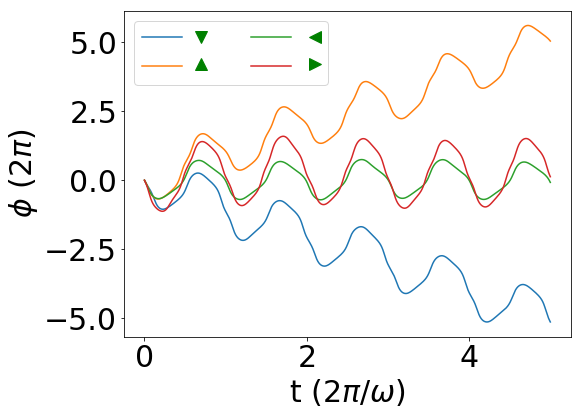

In [33]:
plt.figure(figsize=(8,6))
plt.rcParams.update({'font.size': 30})

tlis=np.linspace(0,5,5*n)
seq=calfull(-0.02/(Ic*1e6),pow(10,1.05),100)
seq1=(seq[90*n:95*n]-seq[n*90])/2/np.pi
plt.plot(tlis,seq1)

seq=calfull(0.05/(Ic*1e6),pow(10,1.03),100)
seq2=(seq[90*n:95*n]-seq[n*90])/2/np.pi
plt.plot(tlis,seq2)

seq=calfull(0.0,pow(10,0.95),100)
seq3=(seq[90*n:95*n]-seq[n*90])/2/np.pi
plt.plot(tlis,seq3)

seq=calfull(0.0/(Ic*1e6),pow(10,1.15),100)
seq4=(seq[90*n:95*n]-seq[n*90])/2/np.pi
plt.plot(tlis,seq4)

plt.legend(['','  ','','  '],ncol=2,prop={'size': 20},loc=2,facecolor='none')

plt.plot(0.7,5.2,'vg',markersize=12)
plt.plot(0.7,4.2,'^g',markersize=12)
plt.plot(2.1,5.2,'<g',markersize=12)
plt.plot(2.1,4.2,'>g',markersize=12)

#plt.plot(np.diff(seq[90*n:100*n],axis=0))
plt.ylabel('$\phi$ (2$\pi$)')
plt.xlabel('t ($2\pi/\omega$)')
#plt.legend(['1.14','1.15','1.16'])
plt.savefig('/home/lz117/Desktop/ShapiroSteps/Fig3/phit.pdf',bbox_inches='tight')
np.mean(np.diff(seq[90*n:100*n],axis=0))/dt*Ic*Rj/(h*f/2/e)

In [132]:
#time sequence analysis
n0=500000
phiseq=calfull(0,pow(10,0.87),n0)

Text(0.5,0,'V')

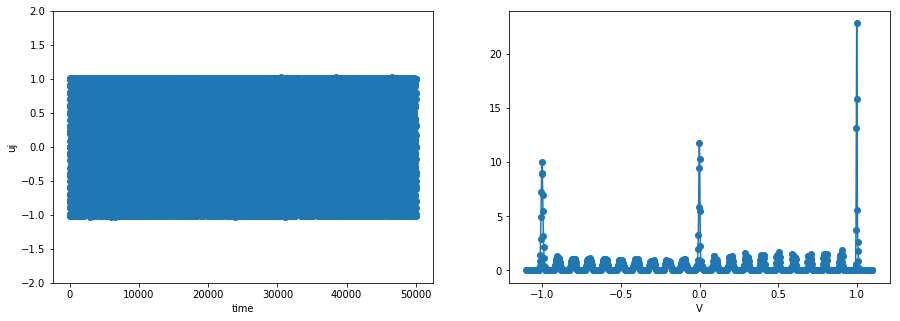

In [136]:
n1=10 #sampling periods to get the voltage
n2=n0/n1
temp=phiseq.reshape(n2,n1*n)
uj=[]
for i in range(n2):
    uj.append((temp[i,n1*n-1]-temp[i,0])/(n1*n*dt)*Ic*Rj*2*e/h/f)

plt.figure(figsize=(15,5))
#voltage time sequence
plt.subplot(121)
plt.plot(uj[n1:-1],'-o')
plt.ylim([-2,2])
plt.ylabel('uj')
plt.xlabel('time')

#voltage histogram
plt.subplot(122)
his=np.histogram(uj,bins=np.linspace(-1.1,1.1,1000),density=True);
plt.plot(his[1][0:-1],his[0],'-o')
plt.xlabel('V')
#plt.ylim([0,100])
#plt.yscale('log')

In [137]:
#find the transition rate
t0=[]#life time of 0
t1=[]#life time of 1
t2=[]#life time of -1
count=0
tol=0.1
for i in range(len(uj)):
    if count==0:
        if uj[i]>1-tol:
            ts=i
            key=1
            count=1
        elif uj[i]<-(1-tol):
            ts=i
            key=-1
            count=1
        elif abs(uj[i])<tol:
            ts=i
            key=0
            count=1
    else:
        if abs(uj[i]-key)>=tol:
            te=i
            count=0
            if key==0:
                t0.append(te-ts)
            elif key==1:
                t1.append(te-ts)
            else:
                t2.append(te-ts)

In [138]:
[np.mean(t0),np.mean(t1),np.mean(t2),(np.mean(t1)+np.mean(t2))/2]

[1.3759041124199214,
 1.8296831314072692,
 1.8195180722891566,
 1.8246006018482128]

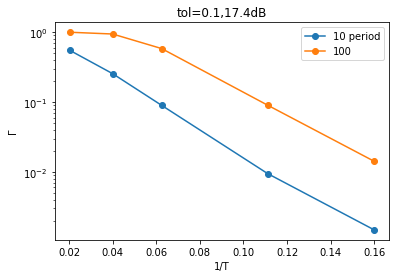

In [142]:
#10 sample period
plt.plot(1./pow(np.array([2.5,3,4,5,7]),2),
1./np.array([679,106,11.16,3.92,1.82]),'-o')
#100 period
plt.plot(1./pow(np.array([2.5,3,4,5,7]),2),
1./np.array([70.7,11.1,1.714,1.06,1]),'-o')

plt.legend(['10 period','100'])
plt.title('tol=0.1,17.4dB')
plt.ylabel('$\Gamma$')
plt.xlabel('1/T')
#plt.xlim([0,0.07])
plt.yscale('log')

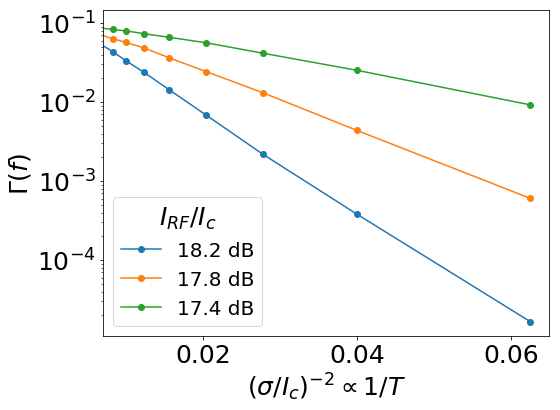

In [215]:
#sample time = 10 periods
plt.figure(figsize=(8,6))
plt.rcParams.update({'font.size': 25})
plt.plot(1./pow(np.array([4,5,6,7,8,9,10,11,13,20]),2),
0.1/np.array([6000,262.4,45.7,14.6,7,4.2,3,2.3,1.65,1.113]),'-o')

plt.plot(1./pow(np.array([4,5,6,7,8,9,10,11,13,20]),2),
0.1/np.array([165,22.8,7.6,4.1,2.75,2.06,1.75,1.575,1.33,1.08]),'-o')

plt.plot(1./pow(np.array([4,5,6,7,8,9,10,11,13,20]),2),
0.1/np.array([10.8,3.95,2.4,1.77,1.51,1.36,1.25,1.2,1.13,1.056]),'-o')


plt.legend(['18.2 dB','17.8 dB','17.4 dB'],prop={'size': 20}, title='$I_{RF}/I_c$')
#plt.title('sample time = 10 periods')
plt.ylabel('$\Gamma (f)$')
plt.xlabel('$(\sigma/I_c)^{-2}\propto 1/T$')
plt.xlim([0.007,0.065])
plt.yscale('log')
plt.savefig('/home/lz117/Desktop/ShapiroSteps/PaperFig/Gamma.pdf',bbox_inches='tight')